In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib.dates import DateFormatter

In [10]:
# Update rcParams to set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [3]:
degradation_setting = "no_degradation"
rain_scenario = "KeinRegen"

In [4]:
def load_systems_data(degradation_setting, rain_scenario, file_type="concentrations"):
    if file_type=="concentrations":
        df_res = pd.read_csv(os.path.join("systems_output", "preprocessed", f"{degradation_setting}_{rain_scenario}.csv"))
        df_res = df_res.loc[df_res.minutes>0,:]
    elif file_type=="flow_rates":
        df_res = pd.read_csv(os.path.join("systems_output", "preprocessed", f"flow_rates_{degradation_setting}_{rain_scenario}.csv"))
        df_res.minutes = df_res.minutes - 70 # ensure time consistency with concentrations
        df_res = df_res.loc[df_res.minutes>0,:]
    else:
        assert False, f"file_type {file_type} not supported"

    df_res.time = pd.to_datetime(df_res.time)

    # drop MW064, RW156 (invalid calculations of ++systems)
    df_res = df_res.loc[~df_res.sampling_point.isin(["MW064", "RW156"]), :]
    # rename sampling locations according to naming in the paper
    df_res.sampling_point = df_res.sampling_point.map({"MW022": "1", "MW023": "2", "MW017": "3", "MW043": "4", "MW048": "5", 
                        "RW157": "6", "MW046": "7", "MW061": "8", "RW143": "9", "RW141": "10",
                        "RW155": "11", "MW059": "12", "RW211": "13", "MW054": "14",
                        "RW126": "15", "MW052": "16"})
    return df_res

In [5]:
df = load_systems_data(degradation_setting, rain_scenario, file_type="concentrations")

## Preprocessing

In [6]:
def simulate_sampling_strategies(df):
    df.time = pd.to_datetime(df.time)
    df["day"]= [el.day for el in df.time]
    df["hour"] = [el.hour for el in df.time]

    # consider only valid observations, i.e. with t>0
    df = df.loc[df.minutes >= 0,:]
    # resample every 5 minutes and fill with the last available value
    resampled_df = df.set_index("time").groupby(["sampling_point", "memilio_id"]).resample("5min").ffill()
    # get hourly measurements
    resampled_df = resampled_df.loc[resampled_df.minutes.mod(60) == 0,:]
    # fix column naming and index
    resampled_df.index = [el[2] for el in resampled_df.index]
    resampled_df = resampled_df.reset_index().rename(columns={"index": "time"})
    # calculate 24h samples
    df_24h = resampled_df.groupby(["sampling_point", "memilio_id", "day"]).mean().reset_index().rename(columns={"copies/l": "24h_sample"})
    # only consider 24h samples with 24h of data
    df_24h = df_24h.loc[df_24h.hour==11.5, ["time", "sampling_point", "memilio_id", "24h_sample"]]
    # extract morning sample column
    df_morning_sample = resampled_df.loc[resampled_df.hour==10,:].rename(columns={"copies/l": "morning_sample"}).loc[:,  ["time", "sampling_point", "memilio_id", "morning_sample"]]
    # combine everything
    df_measurements = pd.merge(resampled_df, pd.merge(df_24h, df_morning_sample, on=["sampling_point", "memilio_id", "time"], how="outer"), on=["sampling_point", "memilio_id", "time"], how="outer")
    return df_measurements

In [7]:
df_sampling = simulate_sampling_strategies(df)

In [8]:
# from wide to long
df_sampling = pd.melt(df_sampling, id_vars=["time", "sampling_point", "memilio_id"], value_vars=["24h_sample", "morning_sample", "copies/l"]).dropna()

## Visualizations

In [9]:
def plot_sampling_strategies(df_sampling, station, save_fig=False):
    fig, ax = plt.subplots(figsize = (12,6)) 
    sns.lineplot(df_sampling.loc[df_sampling.sampling_point==station, :], x="time", y="value", hue="variable")
    # plt.title(f"{station}")
    plt.xlabel('time (days)')
    plt.ylabel('concentration (copies/l)', fontsize=15)
    date_form = DateFormatter("%d")
    ax.xaxis.set_major_formatter(date_form)
    ax.set_xlabel(f"simulation time (days)", fontsize=15)
    ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
    handels, labels = ax.get_legend_handles_labels()
    ax.legend(handels, ['24h sample', 'morning sample','simulation result'], title="sampling protocoll", fontsize=12)    
    if save_fig:
        plt.savefig(os.path.join("systems_output", "plots", "station_concentration", "sampling_strategies", f"{degradation_setting}_{rain_scenario}_{station}.png"))
        plt.close(fig)
    else:
        plt.close(fig)
        return fig

/tmp/ipykernel_76751/1521421945.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


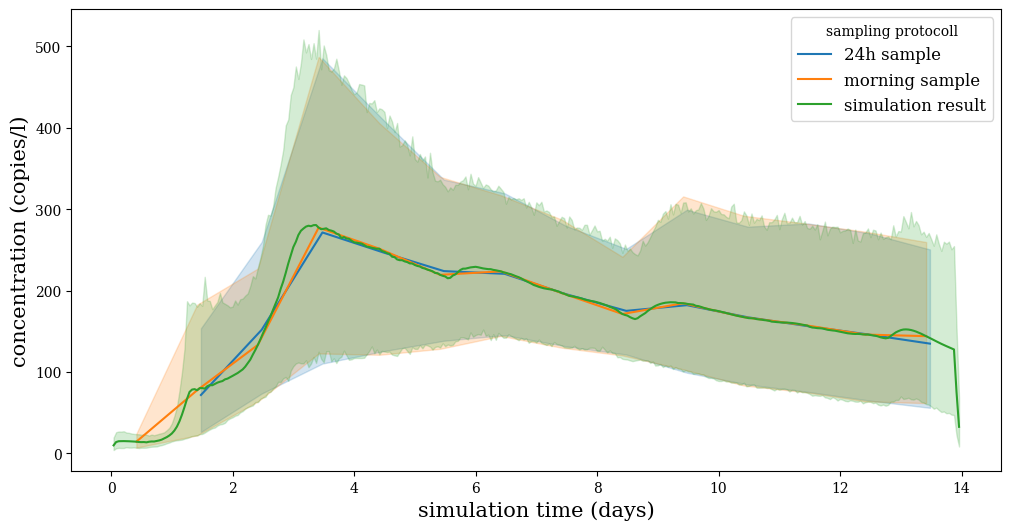

In [12]:
plot_sampling_strategies(df_sampling, "1", save_fig=False)

In [13]:
for station in ["1", "2", "8", "16"]: # df_sampling.sampling_point.unique():
    plot_sampling_strategies(df_sampling, station, save_fig=True)

/tmp/ipykernel_76751/1521421945.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_76751/1521421945.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_76751/1521421945.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_76751/1521421945.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
